In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_paths = glob.glob('dataset/cifar/train/*.png')
data_paths[0]

'dataset/cifar/train/32270_deer.png'

In [5]:
path = data_paths[0]
path

'dataset/cifar/train/32270_deer.png'

In [7]:
gfile = tf.io.read_file(path)
image = tf.io.decode_image(gfile)
image.shape

TensorShape([32, 32, 3])

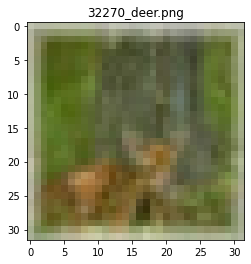

In [9]:
plt.title(os.path.basename(path))
plt.imshow(image)
plt.show()

## tf.data
```Python3
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(func)
```

In [10]:
def read_image(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    return image

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)

<TensorSliceDataset shapes: (), types: tf.string>


In [12]:
tf_image = next(iter(dataset))
tf_image.shape

TensorShape([32, 32, 3])

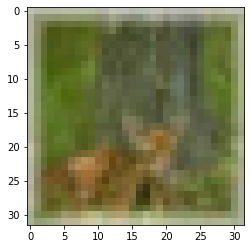

In [19]:
plt.imshow(tf_image)

## Batch
```Python3
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(func)
    dataset = dataset.batch(batch_size)
```

In [21]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)

tf_batch_image = next(iter(dataset))

tf_batch_image.shape

TensorShape([64, 32, 32, 3])

## Shuffle
```Python3
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.map(func)
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=numofdata)
```

In [22]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
dataset = dataset.map(read_image)
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=len(data_paths))

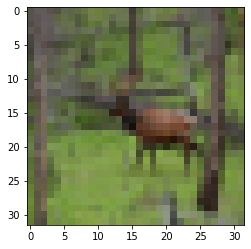

In [23]:
tf_images = next(iter(dataset))

plt.imshow(tf_images[0])
plt.show()

## Get Label
* String

In [24]:
path.split('_')[-1].replace('.png', '')

'deer'

In [25]:
def get_label(path):
    return path.split('_')[-1].replace('.png', '')

train_label_names = [get_label(path) for path in data_paths]
train_label_names[:10]

['deer',
 'cat',
 'deer',
 'truck',
 'automobile',
 'bird',
 'horse',
 'frog',
 'ship',
 'ship']

In [26]:
uniques = np.unique(train_label_names)
uniques

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

### One hot encoding
* numpy
* keras.utils.to_categorical()

In [27]:
uniques == 'frog'

array([False, False, False, False, False, False,  True, False, False,
       False])

In [28]:
np.array(uniques == 'frog', dtype=np.uint8)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [29]:
def onehot_encoding(label):
    return np.array(uniques == label, dtype=np.uint8)

In [30]:
def read_image_and_label(path, label):
    image = read_image(path)
    return image, label

In [31]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((data_paths, train_label_names))
train_dataset = train_dataset.map(read_image_and_label)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(len(data_paths))
train_dataset = train_dataset.repeat() # for repeat epochs

In [33]:
image, label = next(iter(train_dataset))
image.shape, label.shape

(TensorShape([32, 32, 32, 3]), TensorShape([32]))

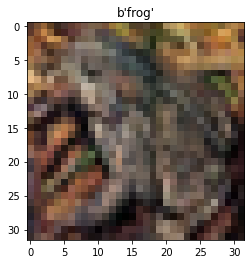

In [35]:
plt.title(np.array(label[0]))
plt.imshow(np.array(image[0]))
plt.show()

## Get Label
* tensorflow (tf.strings)

In [38]:
class_category = np.unique(train_label_names)

def gel_encoded_label(path):
    fname = tf.strings.split(path, '_')[-1]
    cls_name = tf.strings.regex_replace(fname, '.png', '')
    encoded_label = tf.cast(class_category == cls_name, tf.uint8)
    return encoded_label


## Summary

In [57]:
train_paths = glob.glob('dataset/cifar/train/*.png')
test_paths = glob.glob('dataset/cifar/train/*.png')

def get_class_name(path):
    fname = tf.strings.split(path, '_')[-1]
    cls_name = tf.strings.regex_replace(fname, '.png', '')
    return cls_name

class_category = [get_class_name(path) for path in train_paths]
class_category = tf.unique(class_category).y.numpy()
class_category

array([b'deer', b'cat', b'truck', b'automobile', b'bird', b'horse',
       b'frog', b'ship', b'dog', b'airplane'], dtype=object)

In [76]:
def get_onehot_label(path):
    global class_category
    cls_name = get_class_name(path)
    return tf.cast(class_category == cls_name, tf.uint8)

def read_dataset(path):
    # image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.
    
    # label
    onehot_label = get_onehot_label(path)
    
    return image, onehot_label

def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image, label

(32, 32, 3)


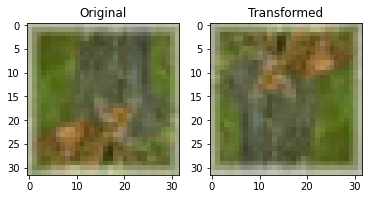

In [77]:
path = train_paths[0]
image, label = read_dataset(path)
transformed, _ = image_preprocess(image, label)
print(transformed.shape)

plt.subplot(121)
plt.title('Original')
plt.imshow(image)

plt.subplot(122)
plt.title('Transformed')
plt.imshow(transformed)

plt.show()

In [78]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(len(train_paths))
train_dataset = train_dataset.repeat()

In [79]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(len(test_paths))
test_dataset = test_dataset.repeat()

### Build Model

In [80]:
num_epochs = 1
batch_size = 32

learning_rate = 0.001
dropout_rate = 0.7
input_shape = (32, 32, 3)
num_classes = 10

In [83]:
from tensorflow.keras import layers

inputs = layers.Input(input_shape)
l = layers.Conv2D(32, (3, 3), padding='SAME')(inputs)
l = layers.Activation('relu')(l)
l = layers.Conv2D(32, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(dropout_rate)(l)

l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.Conv2D(64, (3, 3), padding='SAME')(l)
l = layers.Activation('relu')(l)
l = layers.MaxPool2D(pool_size=(2, 2))(l)
l = layers.Dropout(dropout_rate)(l)

l = layers.Flatten()(l)
l = layers.Dense(512)(l)
l = layers.Activation('relu')(l)
l = layers.Dropout(dropout_rate)(l)
l = layers.Dense(num_classes)(l)
outputs = layers.Activation('softmax')(l)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn-v1')

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training

In [84]:
steps_per_epoch = len(train_paths) // batch_size
validation_steps = len(test_paths) // batch_size

In [85]:
model.fit_generator(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps,
    epochs=num_epochs
)

Instructions for updating:
Please use Model.fit, which supports generators.
1562/1562 [==============================] - 181s 116ms/step - loss: 1.9264 - accuracy: 0.2678 - val_loss: 1.7153 - val_accuracy: 0.3512
